In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

https://blog.csdn.net/qq_26562641/article/details/50351538

In [3]:
pip install scikit-learn==0.22.1

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install xgboost

     |████████████████████████████████| 142.8MB 34.6MB/s eta 0:00:01   |██████▋                         | 29.4MB 6.8MB/s eta 0:00:17     |███████                         | 31.2MB 6.8MB/s eta 0:00:17     |██████████████████▌             | 82.6MB 38.2MB/s eta 0:00:02     |████████████████████████████▍   | 126.7MB 32.6MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install lightgbm

     |████████████████████████████████| 1.2MB 13.1MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import sklearn as skl
print(skl.__version__)
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import metrics
from sklearn import svm
from sklearn import naive_bayes
from sklearn import tree
from sklearn import neighbors
from sklearn import neural_network
from sklearn import ensemble 
import xgboost as xgb
import lightgbm as lgb

0.20.1


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict

In [23]:
def plot_hyperplane(clf, X, y, 
                    h=0.02, 
                    draw_sv=True, 
                    title='hyperplan'):
    # create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    plt.title(title)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap='hot', alpha=0.5)

    markers = ['o', 's', '^']
    colors = ['b', 'r', 'c']
    labels = np.unique(y)
    for label in labels:
        plt.scatter(X[y==label][:, 0], 
                    X[y==label][:, 1], 
                    c=colors[label], 
                    marker=markers[label])
    if draw_sv:
        sv = clf.support_vectors_
        plt.scatter(sv[:, 0], sv[:, 1], c='y', marker='x')

<img src="data/cheat-sheet.png">

In [6]:
df = pd.read_csv("data/IRIS.csv")
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Preprocessing

In [34]:
df.groupby(['species']).count()

,sepal_length,sepal_width,petal_length,petal_width
species,,,,
Iris-setosa,50,50,50,50
Iris-versicolor,50,50,50,50
Iris-virginica,50,50,50,50


In [21]:
# 查看数据缺失情况
df.isnull().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

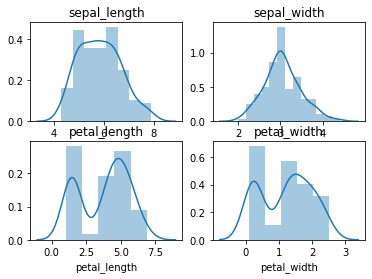

In [20]:
# 查看分布，其中sepal_length 和 sepal_width符合正态分布
plt.figure()
for index, colmn in enumerate(df.columns[:4]):
    plt.subplot(2, 2, index + 1)
    sns.distplot(df[colmn])
    plt.title(colmn)

In [7]:
# 转化为数值标签
le = preprocessing.LabelEncoder()
le.fit(df['species'])
print(le.classes_)
df['species'] = le.transform(df['species'])
df.groupby(['species']).count()
x = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
y = df['species']

['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


In [7]:
x.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [8]:
# data rescaling
# https://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/
x = preprocessing.normalize(x)
x[0]

array([0.80377277, 0.55160877, 0.22064351, 0.0315205 ])

In [9]:
# split train set, test set and validation set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
print(len(x_train))
print(len(y_train))

112
112


Ridge regression

In [19]:
# 岭回归分类
# 原理：在ols的基础上采用L2正则化。ols默认参数都是独立的，否则会导致多重共线性的问题，使用L2正则化能够一定程度上缓解
#      将label分解为正负例，对每个问题视为回归问题，分类结果取决于回归的正负。对于多分类问题则视为多输出回归问题，分类结果取决于最高得分
#      有时被视作搭载线性核的SVM分类器
# 优点：比logistic快
# 输入数据：残差符合正态分布
# 主要参数 alpha：用于约束权重的收敛，越大越收敛，对于多重共线性越鲁棒，越小越发散
# 构造模型
clf = linear_model.RidgeClassifier(alpha=0.7)
clf.fit(x_train, y_train)
clf.score(x_test, y_test)

0.8421052631578947

In [56]:
# 选择超参数
parameters = {'alpha':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]}
clf = linear_model.RidgeClassifier()
clf2 = GridSearchCV(clf, parameters)
clf2.fit(x_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RidgeClassifier(alpha=1.0, class_weight=None,
                                       copy_X=True, fit_intercept=True,
                                       max_iter=None, normalize=False,
                                       random_state=None, solver='auto',
                                       tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0, 1.1, 1.2, 1.3, 1.4, 1.5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [59]:
# 预测结果
pd.DataFrame(clf2.cv_results_)
# alpha=0.7时模型最优

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006406,0.000793,0.008289,0.011074,0.1,{'alpha': 0.1},0.782609,0.913043,0.863636,0.863636,0.863636,0.857312,0.041968,2
1,0.005076,0.000103,0.001615,0.000039,0.2,{'alpha': 0.2},0.782609,0.913043,0.863636,0.863636,0.863636,0.857312,0.041968,2
2,0.005030,0.000053,0.001599,0.000017,0.3,{'alpha': 0.3},0.782609,0.913043,0.863636,0.863636,0.863636,0.857312,0.041968,2
3,0.004986,0.000021,0.001590,0.000024,0.4,{'alpha': 0.4},0.782609,0.913043,0.863636,0.863636,0.863636,0.857312,0.041968,2
4,0.004994,0.000029,0.001588,0.000020,0.5,{'alpha': 0.5},0.782609,0.913043,0.863636,0.863636,0.863636,0.857312,0.041968,2
5,0.004994,0.000037,0.001600,0.000036,0.6,{'alpha': 0.6},0.782609,0.913043,0.863636,0.863636,0.863636,0.857312,0.041968,2
6,0.005002,0.000026,0.001597,0.000023,0.7,{'alpha': 0.7},0.826087,0.913043,0.863636,0.863636,0.863636,0.866008,0.027651,1
7,0.004991,0.000030,0.001585,0.000027,0.8,{'alpha': 0.8},0.826087,0.913043,0.863636,0.818182,0.863636,0.856917,0.033738,8
8,0.004998,0.000039,0.001591,0.000027,0.9,{'alpha': 0.9},0.826087,0.913043,0.863636,0.818182,0.863636,0.856917,0.033738,8
9,0.004966,0.000016,0.001595,0.000022,1,{'alpha': 1.0},0.826087,0.913043,0.863636,0.818182,0.863636,0.856917,0.033738,8


In [65]:
# 各种指标
print(metrics.classification_report(y_test, clf.predict(x_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.88      0.64      0.74        11
           2       0.73      0.92      0.81        12

    accuracy                           0.87        38
   macro avg       0.87      0.85      0.85        38
weighted avg       0.88      0.87      0.87        38



In [67]:
# TP TN FP FN
metrics.multilabel_confusion_matrix(y_test, clf.predict(x_test))

[[[23  0]
  [ 0 15]]

 [[26  1]
  [ 4  7]]

 [[22  4]
  [ 1 11]]]


In [20]:
pred = clf.predict(x_test)
print('average persion: ', metrics.precision_score(y_test, pred, average='macro'))
print('F1 score: ', metrics.f1_score(y_test, pred, average='macro'))
print('recall: ', metrics.recall_score(y_test, pred, average='macro'))
print('acc: ', metrics.accuracy_score(y_test, pred))

average persion:  0.8888888888888888
F1 score:  0.8083333333333332
recall:  0.8181818181818182
acc:  0.8421052631578947


Logistic regression

In [11]:
# Logistic分类
# 原理：使用log函数将因变量转化为概率值（0~1，越接近1越可能是正例），进行分类。在多分类情况下采用ovr，即当前类和其他类作0-1预测
# 优点：可选l1、l2、Elastic-net正则项、简单快速
# 主要参数 penalty:正则化项，可选l1、l2、elasticnet  C：正则化强度，默认1  solver：优化算法  multi-class: 可选ovr、multinomial l1-ratio：只用于选择elasticnet时使用，平衡l1-l2
# 构造模型
lr = linear_model.LogisticRegression(multi_class='ovr')
lr.fit(x_train, y_train)
lr.score(x_test, y_test)

0.8157894736842105

In [14]:
# 选择超参数
parameters = {'C':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]}
lr = linear_model.LogisticRegression(multi_class='ovr')
lr2 = GridSearchCV(lr, parameters)
lr2.fit(x_train, y_train)
pd.DataFrame(lr2.cv_results_)
# 0.4结果最好

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012365,0.005961,0.000703,7.783782e-05,0.1,{'C': 0.1},0.652174,0.695652,0.636364,0.681818,0.636364,0.660474,0.024185,15
1,0.009872,0.000259,0.000677,1.924107e-05,0.2,{'C': 0.2},0.956522,0.956522,0.681818,0.681818,0.636364,0.782609,0.142966,9
2,0.011668,0.000213,0.000664,6.615847e-06,0.3,{'C': 0.3},0.913043,0.869565,0.863636,0.681818,0.636364,0.792885,0.111497,6
3,0.012798,0.000214,0.000689,3.330884e-05,0.4,{'C': 0.4},0.913043,0.869565,0.909091,0.681818,0.636364,0.801976,0.118527,1
4,0.012887,0.000084,0.000680,1.959702e-05,0.5,{'C': 0.5},0.869565,0.869565,0.863636,0.681818,0.636364,0.784190,0.103172,8
5,0.013198,0.000213,0.000664,9.172146e-07,0.6,{'C': 0.6},0.869565,0.826087,0.863636,0.681818,0.636364,0.775494,0.097273,10
6,0.012868,0.000099,0.000696,3.897671e-05,0.7,{'C': 0.7},0.869565,0.826087,0.772727,0.681818,0.636364,0.757312,0.087059,11
7,0.013343,0.000262,0.000687,2.094797e-05,0.8,{'C': 0.8},0.869565,0.826087,0.772727,0.681818,0.636364,0.757312,0.087059,11
8,0.014209,0.000284,0.000681,2.488679e-05,0.9,{'C': 0.9},0.869565,0.826087,0.772727,0.681818,0.636364,0.757312,0.087059,11
9,0.016207,0.003483,0.000711,4.344795e-05,1,{'C': 1.0},0.869565,0.826087,0.772727,0.681818,0.636364,0.757312,0.087059,11


In [17]:
# 预测结果
lr = linear_model.LogisticRegression(multi_class='ovr', C=0.4)
lr.fit(x_train, y_train)
print(lr.predict_proba(x_test[:1]))
print(lr.predict(x_test[:1]))

[[0.23593164 0.37865603 0.38541233]]
[2]


In [18]:
# 模型检验
pred = lr.predict(x_test)
print(metrics.classification_report(y_test, pred))
print('average persion: ', metrics.precision_score(y_test, pred, average='macro'))
print('F1 score: ', metrics.f1_score(y_test, pred, average='macro'))
print('recall: ', metrics.recall_score(y_test, pred, average='macro'))
print('acc: ', metrics.accuracy_score(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.36      0.53        11
           2       0.63      1.00      0.77        12

    accuracy                           0.82        38
   macro avg       0.88      0.79      0.77        38
weighted avg       0.88      0.82      0.79        38

average persion:  0.8771929824561404
F1 score:  0.7691756272401434
recall:  0.787878787878788
acc:  0.8157894736842105


SVM

In [30]:
# 支持向量机
# 原理：在分类问题中构建超平面，边界为1和-1，由支持向量的线性组合而来
# 优点： 适用于高维数据求解、维度大于样本数的数据、可以使用不同的核函数、非线性求解
# 缺点： 不适合用于大规模数据（慢）
# 主要参数 C：惩罚系数，默认1 kernel：核函数，可选linear、poly、rbf、sigmoid、或者其他callable函数，默认rbf gamma：决定了映射空间的分布越大则支持向量越多，影响训练速度
# 构造模型
mysvm = svm.SVC()
mysvm.fit(x_train, y_train)
mysvm.score(x_test, y_test)

1.0

In [33]:
# 选择超参数
param_grid = {'C': np.arange(0.1, 1, 0.1), 'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}
mysvm = svm.SVC()
mysvm2 = GridSearchCV(mysvm, param_grid)
mysvm2.fit(x_train, y_train)
pd.DataFrame(mysvm2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001709,0.000223,0.000770,2.468294e-05,0.1,linear,"{'C': 0.1, 'kernel': 'linear'}",0.347826,0.347826,0.318182,0.681818,0.681818,0.475494,0.168810,27
1,0.001695,0.000045,0.000799,1.939233e-05,0.1,rbf,"{'C': 0.1, 'kernel': 'rbf'}",0.652174,0.652174,0.636364,1.000000,1.000000,0.788142,0.173077,17
2,0.001326,0.000019,0.000730,1.687990e-05,0.1,poly,"{'C': 0.1, 'kernel': 'poly'}",1.000000,0.956522,0.863636,1.000000,1.000000,0.964032,0.052947,3
3,0.002009,0.000014,0.000859,2.322809e-05,0.1,sigmoid,"{'C': 0.1, 'kernel': 'sigmoid'}",0.347826,0.347826,0.318182,0.681818,0.681818,0.475494,0.168810,27
4,0.001482,0.000019,0.000746,6.033451e-06,0.2,linear,"{'C': 0.2, 'kernel': 'linear'}",0.347826,0.391304,0.318182,0.681818,0.727273,0.493281,0.174651,26
5,0.001598,0.000041,0.000774,2.328216e-06,0.2,rbf,"{'C': 0.2, 'kernel': 'rbf'}",0.652174,0.652174,0.636364,1.000000,1.000000,0.788142,0.173077,17
6,0.001317,0.000040,0.000736,1.715063e-05,0.2,poly,"{'C': 0.2, 'kernel': 'poly'}",1.000000,0.956522,0.863636,1.000000,1.000000,0.964032,0.052947,3
7,0.002021,0.000022,0.000838,4.313729e-06,0.2,sigmoid,"{'C': 0.2, 'kernel': 'sigmoid'}",0.347826,0.347826,0.318182,0.681818,0.681818,0.475494,0.168810,27
8,0.001505,0.000044,0.000751,1.363654e-05,0.3,linear,"{'C': 0.30000000000000004, 'kernel': 'linear'}",0.652174,0.652174,0.636364,1.000000,1.000000,0.788142,0.173077,17
9,0.001543,0.000033,0.000784,2.421159e-05,0.3,rbf,"{'C': 0.30000000000000004, 'kernel': 'rbf'}",0.913043,0.956522,0.727273,1.000000,1.000000,0.919368,0.101315,16


In [39]:
# 预测结果
mysvm = svm.SVC(kernel='poly', C=0.3)
mysvm.fit(x_train, y_train)
print(mysvm.predict(x_test))

[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


In [36]:
# 模型检验
print(metrics.classification_report(y_test, mysvm.predict(x_test)))
print('average persion: ', metrics.precision_score(y_test, mysvm.predict(x_test), average='macro'))
print('F1 score: ', metrics.f1_score(y_test, mysvm.predict(x_test), average='macro'))
print('recall: ', metrics.recall_score(y_test, mysvm.predict(x_test), average='macro'))
print('acc: ', metrics.accuracy_score(y_test, mysvm.predict(x_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        12

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38

average persion:  1.0
F1 score:  1.0
recall:  1.0
acc:  1.0


Decision Trees

In [16]:
# 决策树分类
# 原理：根据属性选择度量自顶向下递归构造决策树，并应用剪枝机制
# 输入数据：
# 优点：易于理解，树模型支持可视化，无需数据预处理（除非空值）、能够使用统计方法进行评价、开销小精度高
# 缺点： 会受噪声影响（太深会导致overfitting），缺乏伸缩性
# 主要参数 criterion：有基尼系数(gini)和熵(entropy)，默认基尼  max_depth:树深度，太深可能过拟合
# 构造模型
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)
clf.score(x_test, y_test)

0.868421052631579

In [15]:
# 选择超参数
param_grid = {'criterion':['gini', 'entropy']}
clf = tree.DecisionTreeClassifier()
clf2 = GridSearchCV(clf, param_grid)
clf2.fit(x_train, y_train)
pd.DataFrame(clf2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001725,0.000762,0.000748,0.000148,gini,{'criterion': 'gini'},0.956522,0.956522,0.863636,0.954545,1.000000,0.946245,0.044708,2
1,0.001333,0.000146,0.000767,0.000122,entropy,{'criterion': 'entropy'},1.000000,0.956522,0.863636,1.000000,0.954545,0.954941,0.049799,1


In [18]:
# 预测结果
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(x_train, y_train)
print(clf.score(x_test, y_test))
print(clf.predict(x_test))

0.868421052631579
[1 0 2 1 1 0 1 1 1 1 1 0 0 0 0 1 2 1 1 2 0 2 0 2 1 1 1 2 0 0 0 0 1 0 0 2 1
 0]


In [19]:
# 模型检验
pred = clf.predict(x_test)
print('average persion: ', metrics.precision_score(y_test, pred, average='macro'))
print('F1 score: ', metrics.f1_score(y_test, pred, average='macro'))
print('recall: ', metrics.recall_score(y_test, pred, average='macro'))
print('acc: ', metrics.accuracy_score(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.69      1.00      0.81        11
           2       1.00      0.58      0.74        12

    accuracy                           0.87        38
   macro avg       0.90      0.86      0.85        38
weighted avg       0.91      0.87      0.86        38

average persion:  0.8958333333333334
F1 score:  0.8505523066926576
recall:  0.8611111111111112
acc:  0.868421052631579


[Text(223.20000000000002, 201.90857142857143, 'X[1] <= 0.423\nentropy = 1.583\nsamples = 112\nvalue = [35, 39, 38]'),
 Text(167.4, 170.84571428571428, 'X[2] <= 0.563\nentropy = 1.0\nsamples = 77\nvalue = [0, 39, 38]'),
 Text(111.60000000000001, 139.78285714285715, 'entropy = 0.0\nsamples = 33\nvalue = [0, 33, 0]'),
 Text(223.20000000000002, 139.78285714285715, 'X[1] <= 0.374\nentropy = 0.575\nsamples = 44\nvalue = [0, 6, 38]'),
 Text(167.4, 108.72, 'X[3] <= 0.192\nentropy = 0.378\nsamples = 41\nvalue = [0, 3, 38]'),
 Text(111.60000000000001, 77.65714285714284, 'X[2] <= 0.582\nentropy = 0.845\nsamples = 11\nvalue = [0, 3, 8]'),
 Text(55.800000000000004, 46.59428571428572, 'entropy = 0.0\nsamples = 2\nvalue = [0, 2, 0]'),
 Text(167.4, 46.59428571428572, 'X[3] <= 0.188\nentropy = 0.503\nsamples = 9\nvalue = [0, 1, 8]'),
 Text(111.60000000000001, 15.531428571428563, 'entropy = 0.0\nsamples = 8\nvalue = [0, 0, 8]'),
 Text(223.20000000000002, 15.531428571428563, 'entropy = 0.0\nsamples = 1\n

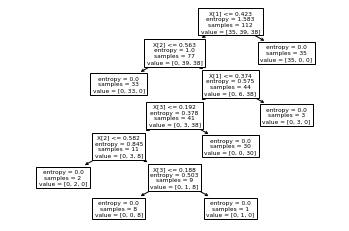

In [20]:
tree.plot_tree(clf)

Naive Bayes

In [21]:
# 高斯朴素贝叶斯分类
# 原理：根据特征属性计算所有划分的条件概率，将特征所属样本概率最大的类别作为划分依据
# 输入数据：假定特征之间相互独立。假定输入数据符合高斯分布
# 优点：快速、简单、对于独立样本的分类准确度高，适合小规模数据集，对缺失值不敏感
# 缺点： 独立假设比较严格，需要知道先验概率（即假设数据集已经包括了所有信息）
# 主要参数 priors:先验概率
# 构造模型
clf = naive_bayes.GaussianNB()
clf.fit(x_train, y_train)
clf.score(x_test, y_test)

1.0

In [23]:
# 模型检验
pred = clf.predict(x_test)
print('average persion: ', metrics.precision_score(y_test, pred, average='macro'))
print('F1 score: ', metrics.f1_score(y_test, pred, average='macro'))
print('recall: ', metrics.recall_score(y_test, pred, average='macro'))
print('acc: ', metrics.accuracy_score(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        12

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38

average persion:  1.0
F1 score:  1.0
recall:  1.0
acc:  1.0


In [24]:
# 分类朴素贝叶斯分类
# 原理：根据特征属性计算所有划分的条件概率，将特征所属样本概率最大的类别作为划分依据，具有离散分布的离散特征的分类
# 输入数据：假定特征之间相互独立。假定输入数据离散分布
# 优点：快速、简单、对于独立样本的分类准确度高
# 主要参数 class_prior:先验概率 alpha：拉普拉斯平滑度
# 构造模型
clf = naive_bayes.CategoricalNB()
clf.fit(x_train, y_train)
clf.score(x_test, y_test)

0.2894736842105263

Perceptron

In [25]:
# 感知机分类
# 原理：是一种线性二项分类器，求分类的超平面。将输入数据映射为特征数据再将其映射为0-1分类，只在分类错误时更新权重（可以设置阈值）
# 输入数据：
# 优点：快速、可用于大数据集
# 主要参数 penalty：正则化选项，可选l1、l2、elastic  alpha：正则化强度
# 构造模型
clf = linear_model.Perceptron(tol=1e-3, random_state=0)
clf.fit(x_train, y_train)
clf.score(x_test, y_test)

0.7105263157894737

In [27]:
# 模型检验
pred = clf.predict(x_test)
print('average persion: ', metrics.precision_score(y_test, pred, average='macro'))
print('F1 score: ', metrics.f1_score(y_test, pred, average='macro'))
print('recall: ', metrics.recall_score(y_test, pred, average='macro'))
print('acc: ', metrics.accuracy_score(y_test, pred))

              precision    recall  f1-score   support

           0       0.62      1.00      0.77        15
           1       0.00      0.00      0.00        11
           2       0.86      1.00      0.92        12

    accuracy                           0.71        38
   macro avg       0.49      0.67      0.56        38
weighted avg       0.52      0.71      0.60        38

average persion:  0.49404761904761907
F1 score:  0.5641025641025641
recall:  0.6666666666666666
acc:  0.7105263157894737


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SGD

In [36]:
# 随机梯度下降
# 原理：每次从数据集中取出一个数据训练，相关算法有批量梯度下降和小批量梯度下降，sklearn的SGD可用在SVM和logistic上
# 输入数据：
# 优点：可用于大数据集
# 缺点
# 主要参数 loss：损失函数，根据参数选择合适的分类器或回归器，默认hinge（线性SVM） penalty：正则化选项，可选l1、l2、elastic  alpha：正则化强度
# 构造模型
clf = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
clf.fit(x_train, y_train)
clf.score(x_test, y_test)

0.7105263157894737

In [35]:
# 选择超参数
param_grid = {'loss': ['log', 'hinge', 'squared_hinge']}
clf = linear_model.SGDClassifier()
clf2 = GridSearchCV(clf, param_grid)
clf2.fit(x_train, y_train)
pd.DataFrame(clf2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_loss,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008211,0.009925,0.000734,0.000095,log,{'loss': 'log'},0.695652,1.000000,0.727273,0.681818,1.000000,0.820949,0.146936,1
1,0.002513,0.000235,0.000676,0.000028,hinge,{'loss': 'hinge'},0.869565,0.652174,0.727273,0.954545,0.772727,0.795257,0.106298,2
2,0.002609,0.000230,0.000703,0.000050,squared_hinge,{'loss': 'squared_hinge'},0.652174,0.695652,0.772727,0.772727,0.681818,0.715020,0.049168,3


In [37]:
# 模型检验 
print(metrics.classification_report(y_test, clf.predict(x_test)))
print('average persion: ', metrics.precision_score(y_test, clf.predict(x_test), average='macro'))
print('F1 score: ', metrics.f1_score(y_test, clf.predict(x_test), average='macro'))
print('recall: ', metrics.recall_score(y_test, clf.predict(x_test), average='macro'))
print('acc: ', metrics.accuracy_score(y_test, clf.predict(x_test)))
# 经多次测试，f1值浮动很大，和每次抽取的数据有关系

              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       0.00      0.00      0.00        11
           2       0.75      1.00      0.86        12

    accuracy                           0.71        38
   macro avg       0.48      0.67      0.56        38
weighted avg       0.51      0.71      0.59        38

average persion:  0.47727272727272724
F1 score:  0.555984555984556
recall:  0.6666666666666666
acc:  0.7105263157894737


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KNN

In [41]:
# k-近邻分类
# 原理：
# 输入数据：但样本抽样不均匀时，要选择RadiusNeighborsClassifier函数创建，并提供半径r
# 优点：可用于非线性、准确度高、不受离群值干扰、理论成熟
# 缺点：计算量大，需要输入数据分类别平衡
# 主要参数 n_neighbors：分几类（默认5） weights：uniform或distance，前者默认各分类平均分布 algorithm：用于计算近邻距离的算法
# 构造模型
clf = neighbors.KNeighborsClassifier(n_neighbors=3)
clf.fit(x_train, y_train)
clf.score(x_test, y_test)

0.9736842105263158

In [39]:
# 选择超参数
param_grid = {'weights': ['uniform', 'distance'], 'algorithm':['ball_tree', 'kd_tree', 'brute']}
clf = neighbors.KNeighborsClassifier(n_neighbors=3)
clf2 = GridSearchCV(clf, param_grid)
clf2.fit(x_train, y_train)
pd.DataFrame(clf2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001320,0.000178,0.002913,0.000306,ball_tree,uniform,"{'algorithm': 'ball_tree', 'weights': 'uniform'}",1.0,1.0,0.909091,1.0,1.0,0.981818,0.036364,1
1,0.001306,0.000154,0.001701,0.000145,ball_tree,distance,"{'algorithm': 'ball_tree', 'weights': 'distance'}",1.0,1.0,0.909091,1.0,1.0,0.981818,0.036364,1
2,0.001225,0.000071,0.002994,0.000138,kd_tree,uniform,"{'algorithm': 'kd_tree', 'weights': 'uniform'}",1.0,1.0,0.909091,1.0,1.0,0.981818,0.036364,1
3,0.001542,0.000708,0.001666,0.000175,kd_tree,distance,"{'algorithm': 'kd_tree', 'weights': 'distance'}",1.0,1.0,0.909091,1.0,1.0,0.981818,0.036364,1
4,0.001091,0.000112,0.002867,0.000341,brute,uniform,"{'algorithm': 'brute', 'weights': 'uniform'}",1.0,1.0,0.909091,1.0,1.0,0.981818,0.036364,1
5,0.001132,0.000117,0.001480,0.000049,brute,distance,"{'algorithm': 'brute', 'weights': 'distance'}",1.0,1.0,0.909091,1.0,1.0,0.981818,0.036364,1


In [42]:
# 模型检验
print(metrics.classification_report(y_test, clf.predict(x_test)))
print('average persion: ', metrics.precision_score(y_test, clf.predict(x_test), average='macro'))
print('F1 score: ', metrics.f1_score(y_test, clf.predict(x_test), average='macro'))
print('recall: ', metrics.recall_score(y_test, clf.predict(x_test), average='macro'))
print('acc: ', metrics.accuracy_score(y_test, clf.predict(x_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.92      1.00      0.96        11
           2       1.00      0.92      0.96        12

    accuracy                           0.97        38
   macro avg       0.97      0.97      0.97        38
weighted avg       0.98      0.97      0.97        38

average persion:  0.9722222222222222
F1 score:  0.9710144927536232
recall:  0.9722222222222222
acc:  0.9736842105263158


Neural network

In [46]:
# 多层感知机分类器
# 原理：基于多层感知机的后向传播算法，目前sklearn只能以最小化熵为依据减小损失函数
# 优点：
# 主要参数  hidden_layer_sizes：每层的神经元数量 activation：激活函数，可选logistic、tanh、relu和identity solver：优化器，可选sgd、lbfgs、adam。learning_rate:学习率
# 构造模型
clf = neural_network.MLPClassifier(activation='tanh', solver='lbfgs', hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(x_train, y_train)
clf.score(x_test, y_test)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


1.0

In [45]:
# 选择超参数
param_grid = {'activation':['logistic', 'tanh', 'relu', 'identity'], 'solver':['sgd', 'lbfgs', 'adam']}
clf = neural_network.MLPClassifier(hidden_layer_sizes=(5, 2), random_state=1)
clf2 = GridSearchCV(clf, param_grid)
clf2.fit(x_train, y_train)
pd.DataFrame(clf2.cv_results_)
# 最好的是 logistic+lbfgs 和 tanh + lbfgs

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.169759,0.004649,0.001005,0.000038,logistic,sgd,"{'activation': 'logistic', 'solver': 'sgd'}",0.304348,0.304348,0.318182,0.318182,0.318182,0.312648,0.006777,9
1,0.117872,0.063185,0.001082,0.000052,logistic,lbfgs,"{'activation': 'logistic', 'solver': 'lbfgs'}",0.956522,1.000000,0.863636,0.636364,1.000000,0.891304,0.136853,3
2,0.190401,0.003777,0.001519,0.000821,logistic,adam,"{'activation': 'logistic', 'solver': 'adam'}",0.304348,0.304348,0.318182,0.318182,0.318182,0.312648,0.006777,9
3,0.168316,0.003318,0.001090,0.000039,tanh,sgd,"{'activation': 'tanh', 'solver': 'sgd'}",0.695652,0.652174,0.500000,0.681818,0.681818,0.642292,0.072549,7
4,0.147128,0.030166,0.001157,0.000073,tanh,lbfgs,"{'activation': 'tanh', 'solver': 'lbfgs'}",0.956522,0.956522,0.863636,1.000000,1.000000,0.955336,0.049802,2
5,0.183567,0.006503,0.001167,0.000105,tanh,adam,"{'activation': 'tanh', 'solver': 'adam'}",0.869565,0.826087,0.772727,0.636364,0.636364,0.748221,0.096345,6
6,0.162162,0.003892,0.001194,0.000220,relu,sgd,"{'activation': 'relu', 'solver': 'sgd'}",0.304348,0.304348,0.318182,0.318182,0.318182,0.312648,0.006777,9
7,0.006554,0.001921,0.001046,0.000145,relu,lbfgs,"{'activation': 'relu', 'solver': 'lbfgs'}",0.347826,0.347826,0.318182,0.363636,0.363636,0.348221,0.016601,8
8,0.186675,0.002529,0.001416,0.000318,relu,adam,"{'activation': 'relu', 'solver': 'adam'}",0.304348,0.304348,0.318182,0.318182,0.318182,0.312648,0.006777,9
9,0.151579,0.004748,0.001212,0.000155,identity,sgd,"{'activation': 'identity', 'solver': 'sgd'}",0.956522,0.913043,0.772727,0.727273,0.681818,0.810277,0.106536,5


In [47]:
# 模型检验
print(metrics.classification_report(y_test, clf.predict(x_test)))
print('average persion: ', metrics.precision_score(y_test, clf.predict(x_test), average='macro'))
print('F1 score: ', metrics.f1_score(y_test, clf.predict(x_test), average='macro'))
print('recall: ', metrics.recall_score(y_test, clf.predict(x_test), average='macro'))
print('acc: ', metrics.accuracy_score(y_test, clf.predict(x_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        12

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38

average persion:  1.0
F1 score:  1.0
recall:  1.0
acc:  1.0


Ensemble methods

In [10]:
# baggingClassfier
bagging = ensemble.BaggingClassifier(neighbors.KNeighborsClassifier(),max_samples=0.5, max_features=0.5)
bagging.fit(x_train, y_train)
bagging.score(x_test, y_test)

1.0

In [11]:
# 模型检验
print(metrics.classification_report(y_test, bagging.predict(x_test)))
print('average persion: ', metrics.precision_score(y_test, bagging.predict(x_test), average='macro'))
print('F1 score: ', metrics.f1_score(y_test, bagging.predict(x_test), average='macro'))
print('recall: ', metrics.recall_score(y_test, bagging.predict(x_test), average='macro'))
print('acc: ', metrics.accuracy_score(y_test, bagging.predict(x_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        12

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38

average persion:  1.0
F1 score:  1.0
recall:  1.0
acc:  1.0


In [12]:
# random forest
clf = ensemble.RandomForestClassifier(n_estimators=10)
clf.fit(x_train, y_train)
clf.score(x_test, y_test)

0.9473684210526315

In [13]:
# 模型检验
print(metrics.classification_report(y_test, clf.predict(x_test)))
print('average persion: ', metrics.precision_score(y_test, clf.predict(x_test), average='macro'))
print('F1 score: ', metrics.f1_score(y_test, clf.predict(x_test), average='macro'))
print('recall: ', metrics.recall_score(y_test, clf.predict(x_test), average='macro'))
print('acc: ', metrics.accuracy_score(y_test, clf.predict(x_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.85      1.00      0.92        11
           2       1.00      0.83      0.91        12

    accuracy                           0.95        38
   macro avg       0.95      0.94      0.94        38
weighted avg       0.96      0.95      0.95        38

average persion:  0.9487179487179488
F1 score:  0.9419191919191919
recall:  0.9444444444444445
acc:  0.9473684210526315


In [14]:
# AdaBoost
lr = tree.DecisionTreeClassifier(criterion='entropy')
clf = ensemble.AdaBoostClassifier(base_estimator=lr, n_estimators=100)
clf.fit(x_train, y_train)
clf.score(x_test, y_test)

0.868421052631579

In [15]:
# 模型检验
print(metrics.classification_report(y_test, clf.predict(x_test)))
print('average persion: ', metrics.precision_score(y_test, clf.predict(x_test), average='macro'))
print('F1 score: ', metrics.f1_score(y_test, clf.predict(x_test), average='macro'))
print('recall: ', metrics.recall_score(y_test, clf.predict(x_test), average='macro'))
print('acc: ', metrics.accuracy_score(y_test, clf.predict(x_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.69      1.00      0.81        11
           2       1.00      0.58      0.74        12

    accuracy                           0.87        38
   macro avg       0.90      0.86      0.85        38
weighted avg       0.91      0.87      0.86        38

average persion:  0.8958333333333334
F1 score:  0.8505523066926576
recall:  0.8611111111111112
acc:  0.868421052631579


In [16]:
# GBDT
clf = ensemble.GradientBoostingClassifier(n_estimators=500, learning_rate=1.0)
clf.fit(x_train, y_train)
clf.score(x_test, y_test)

0.9736842105263158

In [17]:
# 模型检验
print(metrics.classification_report(y_test, clf.predict(x_test)))
print('average persion: ', metrics.precision_score(y_test, clf.predict(x_test), average='macro'))
print('F1 score: ', metrics.f1_score(y_test, clf.predict(x_test), average='macro'))
print('recall: ', metrics.recall_score(y_test, clf.predict(x_test), average='macro'))
print('acc: ', metrics.accuracy_score(y_test, clf.predict(x_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.92      1.00      0.96        11
           2       1.00      0.92      0.96        12

    accuracy                           0.97        38
   macro avg       0.97      0.97      0.97        38
weighted avg       0.98      0.97      0.97        38

average persion:  0.9722222222222222
F1 score:  0.9710144927536232
recall:  0.9722222222222222
acc:  0.9736842105263158


In [18]:
# voting classifier
clf1 = linear_model.LogisticRegression(random_state=1)
clf2 = ensemble.RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = naive_bayes.GaussianNB()
eclf = ensemble.VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')
eclf.fit(x_train, y_train)
eclf.score(x_test, y_test)

1.0

In [19]:
# 模型检验
print(metrics.classification_report(y_test, eclf.predict(x_test)))
print('average persion: ', metrics.precision_score(y_test, eclf.predict(x_test), average='macro'))
print('F1 score: ', metrics.f1_score(y_test, eclf.predict(x_test), average='macro'))
print('recall: ', metrics.recall_score(y_test, eclf.predict(x_test), average='macro'))
print('acc: ', metrics.accuracy_score(y_test, eclf.predict(x_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        12

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38

average persion:  1.0
F1 score:  1.0
recall:  1.0
acc:  1.0


In [10]:
# XGBoost
xg_train = xgb.DMatrix(x_train, label=y_train)
xg_test = xgb.DMatrix(x_test, label=y_test)
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 6
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 6
clf = xgb.train(param, xg_train, 5)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [11]:
clf.predict(xg_test)

array([1., 0., 2., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 2.,
       1., 1., 2., 0., 2., 0., 2., 2., 1., 2., 2., 0., 0., 0., 0., 1., 0.,
       0., 2., 1., 0.], dtype=float32)

In [14]:
# 模型检验
pred = clf.predict(xg_test)
print(metrics.classification_report(y_test, pred))
print('average persion: ', metrics.precision_score(y_test, pred, average='macro'))
print('F1 score: ', metrics.f1_score(y_test, pred, average='macro'))
print('recall: ', metrics.recall_score(y_test, pred, average='macro'))
print('acc: ', metrics.accuracy_score(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.79      1.00      0.88        11
           2       1.00      0.75      0.86        12

   micro avg       0.92      0.92      0.92        38
   macro avg       0.93      0.92      0.91        38
weighted avg       0.94      0.92      0.92        38

average persion:  0.9285714285714285
F1 score:  0.9123809523809524
recall:  0.9166666666666666
acc:  0.9210526315789473


In [15]:
# LightBGM
clf = lgb.LGBMClassifier(num_class=3, objective='multiclass')
clf.fit(x_train, y_train)
clf.predict(x_test)

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 1, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0])

In [17]:
# 模型检验
pred = clf.predict(x_test)
print(metrics.classification_report(y_test, pred))
print('average persion: ', metrics.precision_score(y_test, pred, average='macro'))
print('F1 score: ', metrics.f1_score(y_test, pred, average='macro'))
print('recall: ', metrics.recall_score(y_test, pred, average='macro'))
print('acc: ', metrics.accuracy_score(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.92      1.00      0.96        11
           2       1.00      0.92      0.96        12

   micro avg       0.97      0.97      0.97        38
   macro avg       0.97      0.97      0.97        38
weighted avg       0.98      0.97      0.97        38

average persion:  0.9722222222222222
F1 score:  0.9710144927536232
recall:  0.9722222222222222
acc:  0.9736842105263158
